<a href="https://colab.research.google.com/github/amrios80/GroceryStoreDataset/blob/master/code/taller2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TALLER 2

### Objetivo:
aplicar técnicas de machine learning, las cuales permitan descubrir insights, sugerir accionables al negocio y calcular el valor ganado.

### Contexto del negocio
Apoyo a un Supermercado Inteligente

### Mision
Mediante el uso de modelos de Machine Learning, en conjunto con técnicas de preparación de datos, se espera que usted esté en capacidad de construir el modelo que identifique los productos, y argumente el valor que generará al supermercado los resultados que obtenga.


## 1. Entendimiento y preparación de los datos:

Reporte de entendimiento de datos.

*   Dimensiones del dataset
*   Caracteristicas de las imagenes
*   Indicadores importantes
*   Intergracion de tecnicas de aumento de datos
*   Determinacion de productos y que categorías a emplear


### Cargar librerias

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras


#parameters
use_local=False
rebuild_metadata=False
use_randomforest=False
use_nn_model_2=False
dim_x=128
dim_y=128
flatten_array_size=dim_x*dim_y

model1={ 'name':"", 'precision_score':0, 'recall_score':0, 'f1_score':0, 'roc_auc_score': 0  }
model2={ 'name':"", 'precision_score':0, 'recall_score':0, 'f1_score':0, 'roc_auc_score': 0  }



In [12]:
import pandas as pd
class_names=[]
url_classes="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/classes.csv"
df_classes=pd.read_csv(url_classes)
#Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
df_classes=df_classes[["Coarse Class ID (int)", "Coarse Class Name (str)"]]
unique_classes = df_classes.drop_duplicates()
class_names = unique_classes["Coarse Class Name (str)"].values.tolist()
class_indices = unique_classes.set_index("Coarse Class Name (str)")["Coarse Class ID (int)"].to_dict()

# Display the unique rows
print(class_names)
print(class_indices)

['Apple', 'Avocado', 'Banana', 'Kiwi', 'Lemon', 'Lime', 'Mango', 'Melon', 'Nectarine', 'Orange', 'Papaya', 'Passion-Fruit', 'Peach', 'Pear', 'Pineapple', 'Plum', 'Pomegranate', 'Red-Grapefruit', 'Satsumas', 'Juice', 'Milk', 'Oatghurt', 'Oat-Milk', 'Sour-Cream', 'Sour-Milk', 'Soyghurt', 'Soy-Milk', 'Yoghurt', 'Asparagus', 'Aubergine', 'Cabbage', 'Carrots', 'Cucumber', 'Garlic', 'Ginger', 'Leek', 'Mushroom', 'Onion', 'Pepper', 'Potato', 'Red-Beet', 'Tomato', 'Zucchini']
{'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Lime': 5, 'Mango': 6, 'Melon': 7, 'Nectarine': 8, 'Orange': 9, 'Papaya': 10, 'Passion-Fruit': 11, 'Peach': 12, 'Pear': 13, 'Pineapple': 14, 'Plum': 15, 'Pomegranate': 16, 'Red-Grapefruit': 17, 'Satsumas': 18, 'Juice': 19, 'Milk': 20, 'Oatghurt': 21, 'Oat-Milk': 22, 'Sour-Cream': 23, 'Sour-Milk': 24, 'Soyghurt': 25, 'Soy-Milk': 26, 'Yoghurt': 27, 'Asparagus': 28, 'Aubergine': 29, 'Cabbage': 30, 'Carrots': 31, 'Cucumber': 32, 'Garlic': 33, 'Ginger': 34, 'Leek':

### Generacion del dataset con la metadata y la informacion de las imagenes.

#####*Unifica metadata de train, test y val en un solo dataset*

In [4]:
url_train="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/train.txt"
url_test="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/test.txt"
url_val="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/val.txt"
data_dir="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/"
df_train=pd.read_csv(url_train)
df_train["mode"]="train"
df_test=pd.read_csv(url_test)
df_test["mode"]="test"
df_val=pd.read_csv(url_val)
df_val["mode"]="val"
img_file_columns=["filename","class_id", "coarse_class_id", "mode"]
df_train.columns=img_file_columns
df_test.columns=img_file_columns
df_val.columns=img_file_columns

df_combined = pd.concat([df_train, df_test, df_val], axis=0, ignore_index=True)

print("numero de archivos por modo:")
print(df_combined["mode"].value_counts())

numero de archivos por modo:
mode
train    2639
test     2484
val       295
Name: count, dtype: int64


##### *Funcion que carga una imagen de una url o un directorio en disco.*

In [5]:
def load_image(data_dir, filepath):
        img_path = os.path.join(data_dir, filepath)
        img=[]
        if "http" in img_path:
          url=img_path
          response = requests.get(url)
          if response.status_code == 200:
            image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            if not img.any():
                print(f"Error loading image: {img_path}")
        else:
            img = cv2.imread(img_path)
        if not img.any():
            return []
        return img



#####*Agrega la informacion de la imagen (size_x, size_y, size y channels) al dataset inicial (df_combined) mediante la funcion get_metada*

In [6]:
def get_metadata(df , data_dir="C:/sf/src/taller2/GroceryStoreDataset/dataset/"):
    df["size_x"]=0
    df["size_y"]=0
    df["size"]=0
    df["channels"]=0
    count=0
    for index, row in df.iterrows():
        count=count+1
        filepath=row["filename"]
        img=load_image( data_dir, filepath )
        if img.any():
            size_y, size_x = img.shape[:2]  # Height, Width
            channels = img.shape[2] if len(img.shape) == 3 else 1  # Number of channels
            df.loc[index,"size_x"]=size_x
            df.loc[index,"size_y"]=size_y
            df.loc[index,"channels"]=channels
            df.loc[index,"size"]=size_x*size_y*channels
    print(f'Procesadas {count} imagenes')
    return df




In [23]:
#data_dir="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/"
#df_metadata=get_metadata( df=df_combined, data_dir=data_dir )
df_metadata=[]
if rebuild_metadata:
    #data_dir="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/"
    df_metadata=get_metadata( df=df_combined, data_dir=data_dir )

    df_metadata.to_csv("metadata_20241111.csv", index=False)

    df_metadata.head(3)

    exit()
else:
    df_metadata=pd.read_csv("https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/output/metadata_20241111.csv")


In [24]:
df_metadata.head(3)

,filename,class_id,coarse_class_id,mode,size_x,size_y,size,channels
0,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,train,348,348,363312,3
1,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,train,348,348,363312,3
2,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,train,348,348,363312,3


## 1.1. Dimensiones del dataset



In [25]:
print("numero de imagenes " + str(df_metadata[df_metadata["filename"].str.contains(".jpg")].shape[0]) )
print("archivos por modo:" + str(df_metadata["mode"].value_counts() ))


numero de imagenes 5418
archivos por modo:mode
train    2639
test     2484
val       295
Name: count, dtype: int64


## 1.2 Caracteristicas de las imagenes



In [26]:
df_metadata[["size","size_x","size_y","channels"]].describe()

,size,size_x,size_y,channels
count,5418.000000,5418.000000,5418.000000,5418.0
mean,373661.049834,348.792174,357.120709,3.0
std,33858.825929,9.554136,31.224907,0.0
min,363312.000000,348.000000,348.000000,3.0
25%,363312.000000,348.000000,348.000000,3.0
50%,363312.000000,348.000000,348.000000,3.0
75%,363312.000000,348.000000,348.000000,3.0
max,484416.000000,464.000000,464.000000,3.0


## 1.3 Indicadores

In [27]:
print("cantidad de clases        :"+str(df_metadata["class_id"].nunique()))
print("cantidad de coarse classes:"+str(df_metadata["coarse_class_id"].nunique()))
print("Tamaño en disco           :"+str(df_metadata["size"].sum()/8000000 )+ " MB ")
print("numero de archivos        :"+str(df_metadata.shape[0]))
print("Size promedio             :"+str(df_metadata["size"].mean()/1000 )+ " KB")
print("Categorias                : 3   (Fruit, Packages, Vegetables)")

cantidad de clases        :81
cantidad de coarse classes:43
Tamaño en disco           :253.061946 MB 
numero de archivos        :5418
Size promedio             :373.66104983388703 KB
Categorias                : 3   (Fruit, Packages, Vegetables)


## 1.4 Aumento de datos

In [28]:
import tensorflow as tf
import numpy as np

def preprocess_image(img_path, image_size, flip_horizontal=True, flip_vertical=True, scale_factor=1.0):
    # Load the image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    # Flip the image horizontally
    if flip_horizontal:
        img = tf.image.flip_left_right(img)
    # Flip the image vertically
    if flip_vertical:
        img = tf.image.flip_up_down(img)
    # Scale the image
    img = tf.image.resize(img, [int(image_size[0] * scale_factor), int(image_size[1] * scale_factor)])
    # Expand dimensions and preprocess for DenseNet
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img

## 1.5 Determinacion de productos y que categorías a emplear

Se utilizaran todos los productos y sus categorias con el objetivo de cubrir completamente el inventario existente en la tienda.

### Creación de los conjuntos X, y para train, test y val

In [7]:
def loop_file(filename, mode="train", data_dir="C:/sf/src/taller2/GroceryStoreDataset/dataset/", image_x=128 , image_y=128):
    images_array = []
    labels_array = []

    df=pd.read_csv(filename, header=None)
    df.columns=["filepath", "class", "coarse_class"]
    count=0
    flatten=True   #Aplana la imagen (convierte la imagen en una cadena binaria)
    normalizar=True   #Normaliza los valores de los pixeles de la imagen
    saveWithPickle=False   #Guarda los datos en un archivo pickle
    for index, row in df.iterrows():
        count=count+1
        filepath=row["filepath"]
        category=row["coarse_class"]
        subcategory=row["class"]
        img=load_image(data_dir, filepath)
        if img.any():
            img = cv2.resize(img, (image_x, image_y))  # Resize to a fixed size
            images_array.append(img)
            labels_array.append(category)
    print(f'Procesadas {count} imagenes')
    images=np.array(images_array)
    labels=np.array(labels_array)

    if flatten:

        n_samples, height, width, channels = images.shape
        images = images.reshape((n_samples, height * width * channels))
        print(f"{n_samples} Aplanadas.")
    if normalizar:
        images = images / 255
        print("Normalizadas.")
    X = pd.DataFrame( images )
    if saveWithPickle:
        X.to_pickle(os.path.join("C:/sf/src/taller2/", f"{mode}_images.pkl"))
        print("Guardadas.")
    return X, labels


In [8]:
#Parametros
dim_x=128
dim_y=128
flatten_array_size=dim_x*dim_y


print("Proceso de imagenes.")
print('Obtener X_train')
X_train, y_train = loop_file(filename=url_train, mode="train", data_dir= data_dir)
print('X_train size:', X_train.shape )

print('Obtener X_test')
X_test, y_test = loop_file(filename=url_test, mode="test", data_dir=data_dir)
print('X_test size:', X_test.shape )

print('Obtener X_val')
X_val, y_val = loop_file(filename=url_val, mode="val", data_dir=data_dir)
print('X_val size:', X_val.shape )


Proceso de imagenes.
Obtener X_train
Procesadas 2640 imagenes
2640 Aplanadas.
Normalizadas.
X_train size: (2640, 49152)
Obtener X_test
Procesadas 2485 imagenes
2485 Aplanadas.
Normalizadas.
X_test size: (2485, 49152)
Obtener X_val
Procesadas 296 imagenes
296 Aplanadas.
Normalizadas.
X_val size: (296, 49152)


## 2. Entrenamiento del modelo de machine learning

Utilizando el conjunto de imágenes, construya un modelo que sea capaz de predecir el tipo de producto. Pruebe al menos dos modelos diferentes. Recuerde utilizar de la siguiente manera cada conjunto:

*   train para ajustar los hiperparametros de los modelos
*   test para seleccionar el mejor modelo
*   valid para realizar el analisis de resultados del modelo.

Aproxime su solución en el segundo nivel de categorías (Tipos de productos, i.e manzanas, aguacates, bananas, etc).

## 2.1. Modelo de clasificador Random Forest


In [33]:
from sklearn.ensemble import RandomForestClassifier

model1={}

if use_randomforest:
    print('Entrenar')
    clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=0)
    clf.fit(X_train, y_train)
    print(clf)

    print("obtener predicciones")
    y_pred = clf.predict(X_test)
    print(X_test.shape)

    print("Presentar metricas")
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc



    model1['precision_score']= precision_score(y_test, y_pred, average='weighted')
    model1["recall_score"]   = recall_score(y_test, y_pred, average='weighted')
    model1["f1_score"]       = f1_score(y_test, y_pred, average='weighted')
    model1["roc_auc_score"]  = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')
    print("Precision:")

    print("\nPrecision:", model1["precision_score"] )
    print("\nRecall:", model1["recall_score"])
    print("\nF1:", model1["f1_score"])
    print("\nROC AUC:", model1["roc_auc_score"])


Entrenar
RandomForestClassifier(random_state=0)
obtener predicciones
(2485, 49152)
Presentar metricas


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision:

Precision: 0.19296646740036186

Recall: 0.28209255533199196

F1: 0.19366590608212714

ROC AUC: 0.7848823516907443


## 2.2. Modelo de Red Neuronal

43


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 512)                 │      25,166,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,451,051 (97.09 MB)

 Trainable params: 25,451,051 (97.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 650ms/step - accuracy: 0.0708 - loss: 30.7203 - val_accuracy: 0.0845 - val_loss: 4.8355
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 638ms/step - accuracy: 0.1503 - loss: 3.2967 - val_accuracy: 0.1554 - val_loss: 3.3669
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 629ms/step - accuracy: 0.1771 - loss: 2.8949 - val_accuracy: 0.1926 - val_loss: 3.2649
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 660ms/step - accuracy: 0.1838 - loss: 2.7995 - val_accuracy: 0.1081 - val_loss: 3.2397
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 69s 518ms/step - accuracy: 0.2221 - loss: 2.6764 - val_accuracy: 0.1959 - val_loss: 3.9005
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.2497 - loss: 2.9601
Test Loss: 3.225325584411621
Test Accuracy: 0.2012072503566742
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.51      0.36       276
           1       0.00      0.00      0.00       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


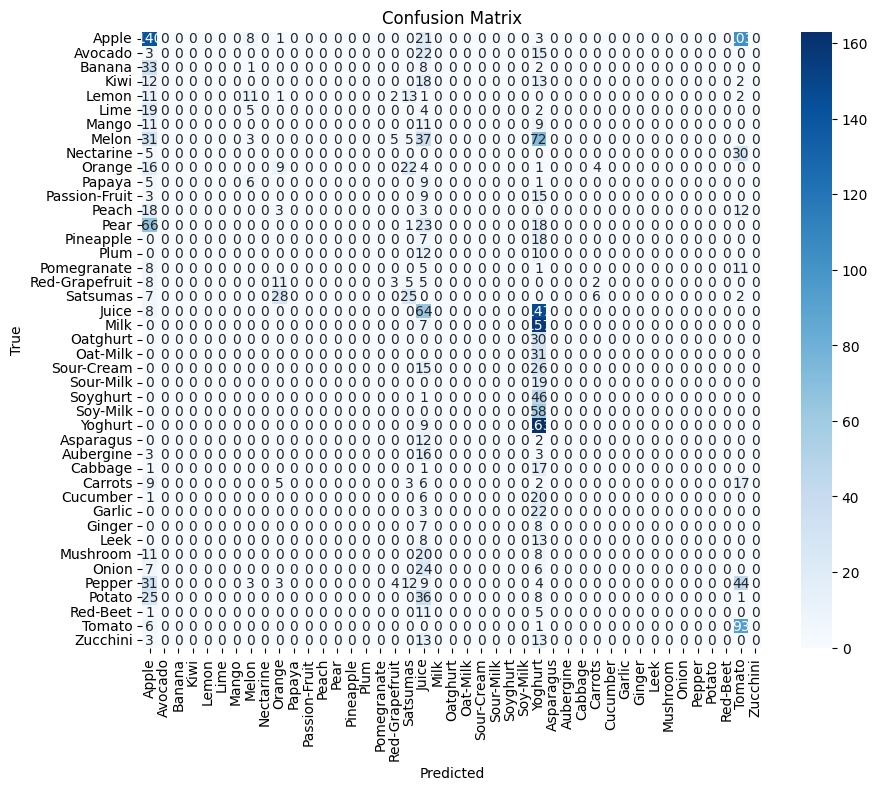

In [11]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras
import numpy as np



unique_values = np.unique(y_train)
print(len(unique_values))


num_categories = 43

y_train_nn = keras.utils.to_categorical(y_train, num_categories)
y_val_nn = keras.utils.to_categorical(y_val, num_categories)
y_test_nn = keras.utils.to_categorical(y_test, num_categories)


model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=(49152,)))
model.add(Dense(units = 512, activation='relu'))
model.add(Dense(units = num_categories, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train_nn, epochs=5, verbose=1, validation_data=(X_val, y_val_nn)
)

# Import necessary libraries
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_nn, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Predict classes for the test set
y_pred_nn = model.predict(X_test)
y_pred_classes_nn = np.argmax(y_pred_nn, axis=1)
y_true_nn = np.argmax(y_test_nn, axis=1)

# Classification Report
print("Classification Report:")


report = classification_report(y_true_nn, y_pred_classes_nn, target_names=class_names, labels=list(class_indices.values()))

import time
timestamp = time.time()

# Save the classification report to a file
with open(f'classification_report_{timestamp}.txt', 'w') as f:
    f.write(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_nn, y_pred_classes_nn)

# Plotting the Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



## 3. Analisis de resultados del modelo

Calcule las métricas de evaluación para su modelo, y explique su significado y su valor para la empresa. Justifique la calidad de su modelo, qué elementos impactaron positivamente dichas métricas, y qué oportunidades de mejora encuentra.

## 3.1. Modelo de clasificador Random Forest


## 3.2. Modelo de Red Neuronal

## 4. Generacion de Valor

y determine la ganancia esperada para el Supermercado con la implementación del modelo por cada predicción acertada, así como el punto a partir del cual la inversión en el modelo empezará a dejar dividendos. Realice una estimación paramétrica, haciendo explícitos todos los supuestos usando datos, incluyendo fuentes aplicables y estadísticas recientes. Para este punto debe considerar:

*   Costos de tiempo asociado al registro de productos
*   Ahorro de tiempo teorico de su modelo
*   Costo de errores del modelo
*   Ahorro real por prediccion acertada
*   ROI tomando en cuenta los costos de desarrollo y depliegue del modelo




## 5. Insights
Redacte un informe ejecutivo o una presentación corta en donde muestre los hallazgos o insights más importantes en términos del modelo y los resultados. Ofrezca una recomendación final para el negocio.

## 6. Bono

Realice su modelo usando el nivel detallado de tipos de productos y sus marcas. (por ej. Manzanas Golden-Delicious, Granny-Smith, etc).

In [ ]:
#!pip install scikit-learn pandas numpy opencv-python


#training
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
#data_dir = '/kaggle/input/apples/golden-delicious/'
#labels_file = os.path.join(data_dir, 'classes.csv')
labels_file ="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/classes.csv"
label_file_columns=["class_name","class_id","coarse_class_name","coarse_class_id","icon_path","product_description_path"]

# Read the labels
labels_df = pd.read_csv(labels_file)
labels_df.columns=label_file_columns
#print(labels_df)

def  load_file(data_dir='', mode="train"):
    train_file=f"{data_dir}{mode}.txt"
    dftrain_file=pd.read_csv(train_file)
    train_file_columns=["filename","class_id", "coarse_class_id"]
    dftrain_file.columns=train_file_columns
    return dftrain_file
#print(dftrain_file)

data_dir ="https://raw.githubusercontent.com/amrios80/GroceryStoreDataset/refs/heads/master/dataset/"

dftrain_file=load_file(data_dir=data_dir, mode="train")

print('rows:' + str(dftrain_file.shape[0]))



In [ ]:
# Function to load images into an array
def load_images(data_dir, df_files, image_x=348, image_y=348 ):
    images = []
    labels = []
    metadata=[]
    for index, row in df_files.iterrows():
        img_path = os.path.join(data_dir, row['filename'])
        #print(img_path)
        img = cv2.imread(img_path)

        # Get dimensions
        size_y, size_x = img.shape[:2]  # Height, Width
        channels = img.shape[2] if len(img.shape) == 3 else 1  # Number of channels

        # Determine color mode
        color_mode = "RGB" if channels == 3 else "Grayscale"

        metadata.append( {"filename": img_path,   "size_x": size_x, "size_y": size_y, "channels": channels, "color_mode": color_mode}   )
        img = cv2.resize(img, (image_x, image_y))  # Resize to a fixed size
        images.append(img)
        labels.append(row['class_id'])



    return np.array(images), np.array(labels)


def preprocess_dataset(data_dir='', mode="train" , normalize=False, flatten=False, image_x=348, image_y=348 ):
    dftrain_file = load_file(data_dir, mode)
    images, labels = load_images(data_dir, dftrain_file , image_x, image_y )
    # Normalize the images
    # This line normalizes the pixel values of the images by dividing them by 255.0. This scales the pixel values from the original range (typically 0-255 for RGB images) to the range 0-1, which is a common normalization technique for neural networks.
    if normalize:
        images = images / 255.0
    # Flatten the images for the classifier
    #This reshapes the images from their original shape
    # (likely (n_samples, height, width, channels)) to a flat 2D array.
    # The new shape is (n_samples, height * width * channels), where:
    # height * width * channels represents the total number of pixels in each image.
    # n_samples is the number of images in the dataset.
    if flatten:
        n_samples, height, width, channels = images.shape
        print('before shaping:')
        print(images.shape)
        print( n_samples, height, width, channels )
        images = images.reshape((n_samples, height * width * channels))
        print('after reshaping:')
        print(images.shape)
    return images, labels


def preprocess_dataset_no_flattening(data_dir='', mode="train" ):
    dftrain_file = load_file(data_dir, mode)
    images, labels = load_images(data_dir, dftrain_file, image_x=128, image_y=128 )
    # Normalize the images
    # This line normalizes the pixel values of the images by dividing them by 255.0. This scales the pixel values from the original range (typically 0-255 for RGB images) to the range 0-1, which is a common normalization technique for neural networks.
    images = images / 255.0
    print(images.shape)
    return images, labels

X_train, y_train = preprocess_dataset( data_dir,"train" )
print(X_train)
print(X_train.shape)
print(y_train)

X_test, y_test = preprocess_dataset( data_dir,"test" )


# Encode the labels if necessary
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# labels = le.fit_transform(labels)

# Split the data
#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.0, random_state=42)
#X_train =images
#y_train =labels

print(X_train.shape)

###############

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the classifier
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the classifier
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Accuracy: {accuracy * 100:.2f}%')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D


X_train, y_train = preprocess_dataset_no_flattening( data_dir,"train" )
X_test, y_test = preprocess_dataset_no_flattening( data_dir,"test" )

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'CNN Accuracy: {accuracy * 100:.2f}%')


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_
print(f'Best Parameters: {best_params}')
print(f'Best Accuracy: {best_accuracy * 100:.2f}%')


In [ ]:
from sklearn.ensemble import VotingClassifier

# Initialize individual classifiers
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
clf3 = LogisticRegression(random_state=42)

# Initialize the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', clf1), ('xgb', clf2), ('lr', clf3)], voting='soft')

# Train the classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Voting Classifier Accuracy: {accuracy * 100:.2f}%')


In [ ]:
5. Feature Engineering
Improving the quality of your features can significantly boost model performance. This includes creating new features, transforming existing ones, and selecting the most relevant features.

6. Data Augmentation
For image data, augmenting your dataset by applying transformations like rotations, flips, and color adjustments can help improve model generalization.